***
# <font color=red>Fairness with AutoMLx</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle AutoMLx Team </font></p>

***

AutoMLx Fairness Demo version 23.2.0.

Copyright © 2023, Oracle and/or its affiliates.

Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl/

## Overview of this Notebook
In this notebook, we explore the fairness features of AutoMLx package. We start by training an AutoML model on the Census Income dataset. Later, we provide examples of how to evaluate the fairness of the model and the dataset. We also explore how the provided explanation techniques may help us gain more insight on the fairness of our model.

## Prerequisites
  - Experience level: Novice (Python and Machine Learning)
  - Professional experience: Some industry experience
  
Compatible conda pack: Oracle AutoML and Model Explanation for Python 3.8 (version 3.0)

## Table of Contents

- <a href='#pre'>0. Preliminaries</a>
- <a href='#quick'>1. Quick Start</a>
  - <a href='#quick-load'>1.1. Load the Data</a>
  - <a href='#quick-train'>1.2. Train and evaluate an AutoML model</a>
  - <a href='#quick-fairness'>1.3. Evaluate the Fairness of the Model by Computing Statistical Parity</a>
  - <a href='#quick-importance'>1.4. Compute Fairness Feature Importance</a>
- <a href='#load-data'>2. The Census Income dataset</a>
- <a href='#Fairness'>3. Unintended Bias and Fairness</a>
  - <a href='#Metrics-overview'>3.0. Overview of the Fairness Metrics </a>
  - <a href='#Fairness-measure'>3.1. Unintended Bias Detection</a>
    - <a href='#Fairness-measure_model'>3.1.1. Measure the Compliance of a Model with a Fairness Metric </a>
      - <a href='#Train-model-sklearn'> Train a Model Using Scikit-learn </a>
      - <a href='#Train-model-automl'> Train a Modele Using AutoML </a>
    - <a href='#Fairness-measure_data'>3.1.2. Measure the Compliance of the True Labels of a Dataset with a Fairness Metric </a>
    - <a href='#Fairness-measure_other'>3.1.3. Other Fairness Metrics </a>
- <a href='#MLX'>4. Revealing Bias with Explainability </a>
  - <a href='#MLX-initializing'>4.1. Initializing an MLExplainer </a>
  - <a href='#MLX-global'>4.2. Model Explanations (Global Feature Importance)</a>
  - <a href='#MLX-fairness-feature-importance'>4.3. Model Fairness Explanations (Fairness Feature Importance)</a>
  - <a href='#MLX-fairness-vs-global'>4.4. Global vs Fairness Feature Importance</a>
  - <a href='#MLX-dependency-accuracy'>4.5. Feature Dependence Explanations (Important to Accuracy)</a>
  - <a href='#MLX-dependency-fairness'>4.6. Feature Dependence Explanations (Important to Fairness)</a>
  - <a href='#MLX-local-shap'>4.7. Local Feature Importance with Kernel SHAP</a>
  - <a href='#MLX-fast-cf'>4.8. Fast Counterfactual Explanations</a>
- <a href='#MLX-fairness-mitigation'>5. Enforcing Fairness in the Model is Not Straight-forward</a>
- <a href='#ref'>References</a>
  

<a id='pre'></a>
## Preliminaries

Here we import some required libarries.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Load the required modules.

In [2]:
import copy
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Settings for plots
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

import automl
from automl import init

<a id='quick'></a>
## Quick Start
Here, we give an overview of the key features. We first load the Census Income dataset, train a model on it, evaluate its accuracy and fairness, and compute its fairness feature importance. All of these steps will be revisited again, but with more detail through the rest of the notebook.

<a id='quick-load'></a>
### Load the Data

In [3]:
dataset = fetch_openml(name='adult', as_frame=True)
df, y = dataset.data, dataset.target

# Several of the columns are incorrectly labeled as category type in the original dataset
numeric_columns = ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
for col in df.columns:
    if col in numeric_columns:
        df[col] = df[col].astype(int)
    

X_train, X_test, y_train, y_test = train_test_split(df,
                                                    y.map({'>50K': 1, '<=50K': 0}).astype(int),
                                                    train_size=0.7,
                                                    random_state=0)

X_train.shape, X_test.shape

((34189, 14), (14653, 14))

<a id='quick-train'></a>
### Train and evaluate an AutoML model
The AutoML API is quite simple to work with. We create an instance of the pipeline. Next, the training data is passed to `fit`.

In [4]:
model = automl.Pipeline(task='classification')
model.fit(X_train, y_train)

[2023-05-01 01:42:53,384] [automl.pipeline] Random state (7) is used for model builds
[2023-05-01 01:42:53,396] [automl.xengine] Using Dask Execution
[2023-05-01 01:42:54,234] [automl.pipeline] Dataset shape: (34189, 14)
[2023-05-01 01:42:54,245] [automl.pipeline] Running Auto-Preprocessing
[2023-05-01 01:42:54,498] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (34189, 15), cv: 5
[2023-05-01 01:42:54,552] [automl.pipeline] SVC, KNeighborsClassifier are disabled for datasets with > 10K samples or > 1K features
[2023-05-01 01:42:54,553] [automl.pipeline] Running Model Selection
[2023-05-01 01:43:11,900] [automl.pipeline] Model Selection completed. Selected model: ['LGBMClassifier']
[2023-05-01 01:43:11,902] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (34189, 15), Valid Shape: None, CV: 5, Class counts: [25955  8234]
[2023-05-01 01:43:14,434] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (34189, 15), Valid Shape: None, CV: [(1234

Pipeline(model_list=['DecisionTreeClassifier', 'ExtraTreesClassifier',
                     'GaussianNB', 'LGBMClassifier', 'LogisticRegression',
                     'RandomForestClassifier', 'SVC', 'XGBClassifier',
                     'TorchMLPClassifier', 'CatBoostClassifier'])

In [5]:
y_proba = model.predict_proba(X_test)
score_original = roc_auc_score(y_test, y_proba[:, 1])

print(f'Score on test data: {score_original:.2f}')

Score on test data: 0.91


<a id='quick-fairness'></a>
### Evaluate Fairness of the Model by Computing Statistical Parity
Among the several fairness metrics available in the AutoMLx package, we compute the statistical parity of the model on test data.

In [6]:
from automl.fairness.metrics import ModelStatisticalParityScorer

fairness_score = ModelStatisticalParityScorer(protected_attributes='sex')
parity_test_model = fairness_score(model, X_test)
print(f'Statistical parity of the model on test data (lower is better): {parity_test_model:.2f}')

Statistical parity of the model on test data (lower is better): 0.33


<a id='quick-importance'></a>
### Compute Fairness Feature Importance
Using the fairness feature importance, we can gain insight on which features contribute the most to model unfairness.

In [7]:
explainer = automl.MLExplainer(model,
                               X_train,
                               y_train,
                               target_names=["<=50K", ">50K"],
                               task="classification")

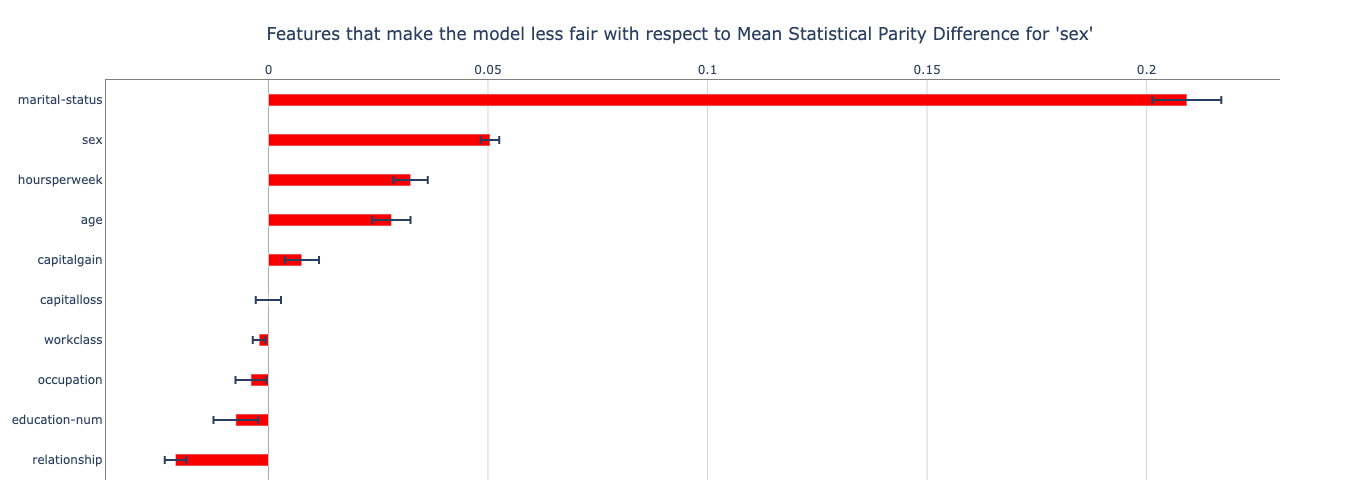

In [8]:
fairness_exp = explainer.explain_model_fairness(protected_attributes='sex', 
                                                scoring_metric='statistical_parity')
fairness_exp.show_in_notebook()

<a id='load-data'></a>
## The Census Income dataset
We start by reading in the dataset from OpenML.

In [9]:
dataset = fetch_openml(name='adult', as_frame=True)
df, y = dataset.data, dataset.target

Lets look at a few of the values in the data

In [10]:
df.head()

age         workclass    fnlwgt  education  education-num  \
0   2         State-gov   77516.0  Bachelors           13.0   
1   3  Self-emp-not-inc   83311.0  Bachelors           13.0   
2   2           Private  215646.0    HS-grad            9.0   
3   3           Private  234721.0       11th            7.0   
4   1           Private  338409.0  Bachelors           13.0   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

  capitalgain capitalloss hoursperweek native-country  
0           1           0            2  United-States  
1           0           0            0  United-States  
2           0           0            2  United-States  
3           0           0            2  United-States  
4           0           0            2           Cuba

The Adult dataset contains a mix of numerical and string data, making it a challenging problem to train machine learning models on.

We visualize the distribution of the target variable in the training data.

[Text(0, 0, '11687'), Text(0, 0, '37155')]

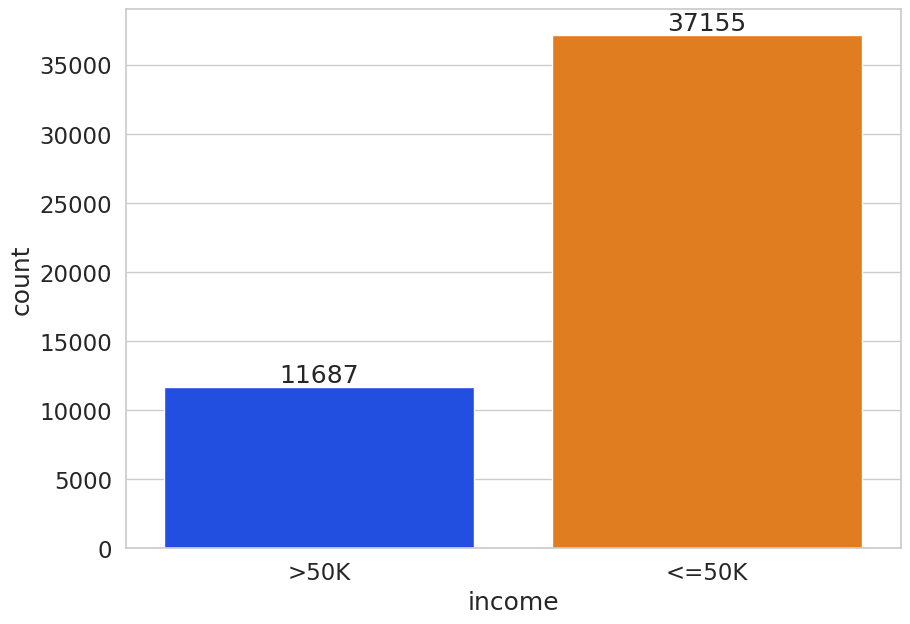

In [11]:
y_df = pd.DataFrame(y)
y_df.columns = ['income']

ax = sns.countplot(x="income", data=y_df)
ax.bar_label(ax.containers[0])

We now visualize the distribution of the target variable conditioned on values of `sex`. We can already see some biases in this dataset.

(0.0, 100.0)

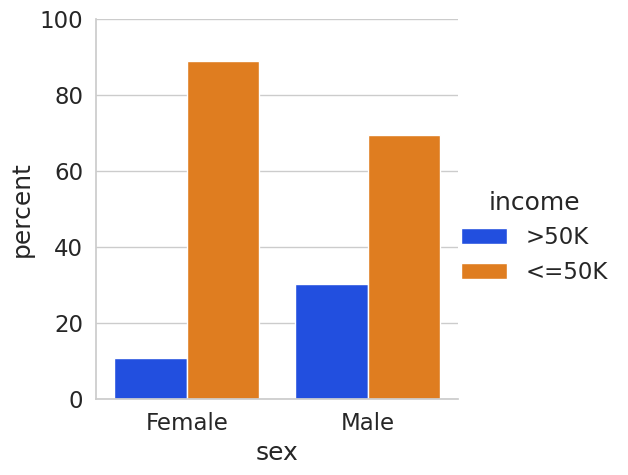

In [12]:
df1 = pd.concat([df, y_df], axis=1)

df1 = df1.groupby('sex')['income'].value_counts(normalize=True)
df1 = df1.mul(100).reset_index()
df1.columns = ['sex', 'income', 'percent']

g = sns.catplot(x='sex', y='percent', hue='income', kind='bar', data=df1)
g.ax.set_ylim(0,100)

We now separate the predictions (`y`) from the training data (`X`) for both the training (70%) and test (30%) datasets. The training set will be used to create a Machine Learning model using AutoML, and the test set will be used to evaluate the model's performance on unseen data.

In [13]:
# Several of the columns are incorrectly labeled as category type in the original dataset
numeric_columns = ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
for col in df.columns:
    if col in numeric_columns:
        df[col] = df[col].astype(int)
    

X_train, X_test, y_train, y_test = train_test_split(df,
                                                    y.map({'>50K': 1, '<=50K': 0}).astype(int),
                                                    train_size=0.7,
                                                    random_state=0)

X_train.shape, X_test.shape

((34189, 14), (14653, 14))

<a id='Fairness'></a>
## Unintended Bias and Fairness
Protected attributes are referred to as features that may not be used as the basis for decisions (for example, race, gender, etc.). When machine learning is applied to decision-making processes involving humans, one should not only look for models with good performance, but also models that do not discriminate against protected population subgroups.

<a id='Metrics-overview'></a>
### Overview of the Fairness Metrics
We provide a table summarizing the fairness metrics in the AutoMLx package. Choosing the right fairness metric for a particular application is critical; it requires domain knowledge of the complete sociotechnical system. Moreover, different metrics bring in different perspectives and sometimes the data/model might need to be analyzed for multiple fairness metrics. Therefore, this choice is based on a combination of the domain, task at hand, societal impact of model predictions, policies and regulations, legal considerations, etc. and cannot be fully automated. However, we hope that the table below will help give some insights into which fairness metric is best for your application.

Machine learning models that decide outcomes affecting individuals can either be assistive or punitive. For example, a model that classifies whether or not a job applicant should be interviewed is assistive, because the model is screening for individuals that should receive a positive outcome. In contrast, a model that classifies loan applicants as high risk is punitive, because the model is screening for individuals that should receive a negative outcome. For models used in assistive applications, it is typically important to minimize false negatives (for example, to ensure individuals who deserve to be interviewed are interviewed), whereas in punitive applications, it is usually important to minimize false positives (for example, to avoid denying loans to individuals that have low credit risk). In the spirit of fairness, one should therefore aim to minimize the disparity in false negative rates across protected groups in assistive applications whilst minimizing the disparity in false positive rates for punitive applications. In the following table, we have classified each metric based on whether or not it is most appropriate for models used in assistive or punitive applications (or both). For further explanations, please refer to this <a href='https://textbook.coleridgeinitiative.org/chap-bias.html#sec:punitiveexample'>book</a>.

| Metric  |  Dataset | Model  | Punitive | Assistive | Perfect score means  |
|:-|:-:|:-:|:-:|:-:|:-|
| Consistency          | ✓  |   | NA | NA | Neighbors (k-means) have the same labels  |
| Smoothed EDF         | ✓  |   | NA | NA | Sub-populations have equal probability of positive label (with log scaling of deviation)  |
| Statistical Parity   | ✓  | ✓ | ✓ |  | Sub-populations have equal probability of positive prediction  |
| True Positive Rates  |    | ✓ |  | ✓ | Sub-populations have equal probability of positive prediction when their true label is positive  |
| False Positive Rates |    | ✓ | ✓ |  | Sub-populations have equal probability of positive prediction when their true label is negative  |
| False Negative Rates |    | ✓ |  | ✓ | Sub-populations have equal probability of negative prediction when their true label is positive  |
| False Omission Rates |    | ✓ |  | ✓ | Sub-populations have equal probability of a positive true label when their prediction is negative  |
| False Discovery Rates|    | ✓ | ✓ |  | Sub-populations have equal probability of a negative true label when their prediction is positive  |
| Equalized Odds       |    | ✓ | ✓ | ✓ | Sub-populations have equal true positive rate and equal false positive rate |
| Error Rates          |    | ✓ |  | ✓ | Sub-populations have equal probability of a false prediction |
| Theil Index          |    | ✓ |  | ✓ | Error rates are the same for sub-populations and whole population (deviations are measured using entropy).  |

<a id='Fairness-measure'></a>
### Unintended Bias Detection
The `automl.fairness.metrics` module provides metrics dedicated to assessing and checking whether the model predictions and/or true labels in data comply with a particular fairness metric.
For this example, we will take a look at the statistical parity metric. This metric, also known as demographic parity, measures how much a protected group's outcome varies when compared to the rest of the population. Thus, such fairness metrics denote differences in error rates for different demographic groups/protected attributes in data. Therefore, these metrics are to be **minimized** to decrease discrepancies in model predictions with respect to specific groups of people. Traditional classification metrics such as accuracy, on the other hand, are to be maximized.

<a id='Fairness-measure_model'></a>
#### Measure the Compliance of a Model with a Fairness Metric
In the context of the Adult Census Income dataset, if we want to measure fairness with respect to the `sex` attribute, statistical parity corresponds to the disparity between the model's rate of predicting a `>50k` income between men and women.
Model fairness metrics are available as scikit-learn compatible scorers, taking in a list of `protected_attributes` at creation and then being called with a `model`, `X`, and `y` on which to measure fairness - note that the fairness features are not limited to AutoML models.
By default, the fairness metric will measure the *difference* between a subgroup's outcome and that of the rest of the population, returning the *mean* disparity over all subgroups. These two options can be changed at the creation of the metric, using the `distance_measure` and `reduction` arguments, respectively.

<a id='Train-model-sklearn'></a>
##### Train a Model Using Scikit-learn
We first train a simple sklearn random forest and then evaluate its performance and fairness.


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

sklearn_model = sklearn.pipeline.Pipeline(
    steps=[("preprocessor", OneHotEncoder(handle_unknown="ignore")), ("classifier", RandomForestClassifier())]
)
sklearn_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', OneHotEncoder(handle_unknown='ignore')),
                ('classifier', RandomForestClassifier())])

We use the `roc_auc_score` scoring metric to evaluate the performance of this model on unseen data (`X_test`).

In [15]:
y_proba = sklearn_model.predict_proba(X_test)
score = roc_auc_score(y_test, y_proba[:, 1])

print(f'Score on test data: {score:.2f}')

Score on test data: 0.90


Now, we can also compute the statistical parity of the model on test data.

In [16]:
fairness_score = ModelStatisticalParityScorer(protected_attributes='sex')
parity_test_sklearn_model = fairness_score(sklearn_model, X_test)
print(f'Statistical parity of the sklearn model on test data (lower is better): {parity_test_sklearn_model:.2f}')

Statistical parity of the sklearn model on test data (lower is better): 0.18


<a id='Train-model-automl'></a>
##### Train a Model Using AutoML
One can also use the fairness metrics to score AutoML models, which is even easier, because it will handle all of the dataset pre-processing and also select the best learning algorithm.

In [17]:
model = automl.Pipeline(task='classification')
model.fit(X_train, y_train)

[2023-05-01 01:45:48,883] [automl.pipeline] Random state (7) is used for model builds
[2023-05-01 01:45:48,897] [automl.pipeline] Dataset shape: (34189, 14)
[2023-05-01 01:45:48,908] [automl.pipeline] Running Auto-Preprocessing
[2023-05-01 01:45:49,163] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (34189, 15), cv: 5
[2023-05-01 01:45:49,188] [automl.pipeline] SVC, KNeighborsClassifier are disabled for datasets with > 10K samples or > 1K features
[2023-05-01 01:45:49,189] [automl.pipeline] Running Model Selection
[2023-05-01 01:45:57,422] [automl.pipeline] Model Selection completed. Selected model: ['LGBMClassifier']
[2023-05-01 01:45:57,425] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (34189, 15), Valid Shape: None, CV: 5, Class counts: [25955  8234]
[2023-05-01 01:45:59,539] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (34189, 15), Valid Shape: None, CV: [(12342, 6838), (12342, 6838), (12342, 6838), (12342, 6838), (12342, 6

Pipeline(model_list=['DecisionTreeClassifier', 'ExtraTreesClassifier',
                     'GaussianNB', 'LGBMClassifier', 'LogisticRegression',
                     'RandomForestClassifier', 'SVC', 'XGBClassifier',
                     'TorchMLPClassifier', 'CatBoostClassifier'])

Again, we use the `roc_auc_score` scoring metric to evaluate the performance of this model on unseen data (`X_test`).

In [18]:
y_proba = model.predict_proba(X_test)
score_original = roc_auc_score(y_test, y_proba[:, 1])

print(f'Score on test data: {score_original:.2f}')

Score on test data: 0.91


We can now go on with this model to show-case the rest of fairness features and metrics, but everything could work for a scikit-learn model as well.

In [19]:
fairness_score = ModelStatisticalParityScorer(protected_attributes='sex')
parity_test_model = fairness_score(model, X_test)
print(f'Statistical parity of the model on test data (lower is better): {parity_test_model:.2f}')

Statistical parity of the model on test data (lower is better): 0.33


Below is another way to visually see statistical parity. The difference of the bars amounts to `0.33`.

[Text(0, 0, '0.15'), Text(0, 0, '0.48')]

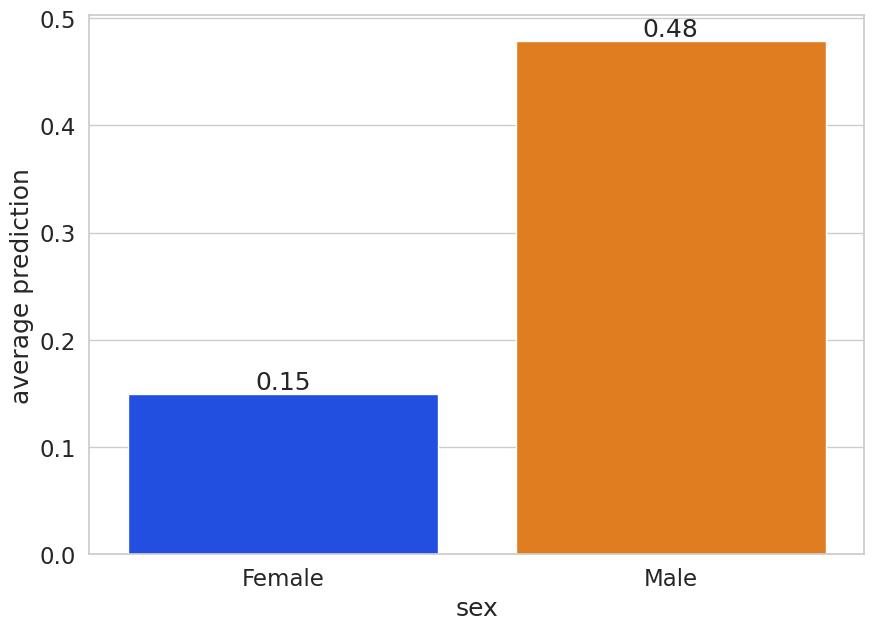

In [20]:
y_pred = model.predict(X_train)

df_predict = X_train.copy()
df_predict['model prediction probability'] = y_pred

pred_per_sex = df_predict.groupby('sex').mean('model prediction probability').reset_index()
pred_per_sex = pred_per_sex.rename(columns={'model prediction probability': 'average prediction'})

ax = sns.barplot(data=pred_per_sex, x='sex', y='average prediction')
ax.bar_label(ax.containers[0], fmt='%.2f')

We can see here that our tuned model has a statistical disparity with respect to sex of `0.33`, meaning that among the two values of `sex` in the dataset, the model predicts favorable outcomes for one sex 33% more than the other.

Model fairness metrics are also available as functions taking as inputs `y_true`, `y_pred` and `subgroups` - though note that statistical parity, by definition, does not require the true labels.

In [21]:
from automl.fairness.metrics import model_statistical_parity

y_pred = model.predict(X_test)
subgroups = X_test[['sex']]

parity_test_model = model_statistical_parity(y_pred=y_pred, subgroups=subgroups)
print(f'Statistical parity of the model on test data (lower is better): {parity_test_model:.2f}')

Statistical parity of the model on test data (lower is better): 0.33


<a id='Fairness-measure_data'></a>
#### Measure the Compliance of the True Labels of a Dataset with a Fairness Metric
Given a dataset with some ground truth labels, we can check whether those true labels satisfy a particular fairness metric of concern. In this context, statistical parity measures the disparity of positive label rates between subgroups and the rest of the population.
Dataset fairness metrics are available as scikit-learn compatible scorers, taking in a list of `protected_attributes` at creation and then being called with a `model`, `X` and `y` on which to measure fairness, with `model` being an ignored and optional argument.

In [22]:
from automl.fairness.metrics import DatasetStatisticalParityScorer

DSPS = DatasetStatisticalParityScorer(protected_attributes='sex')

parity_test_data = DSPS(X=X_test, y_true=y_test)

Dataset fairness metrics are also available as functions taking as inputs `y_true` and `subgroups`.

In [23]:
from automl.fairness.metrics import dataset_statistical_parity

subgroups = X_test[['sex']]

parity_test_data = dataset_statistical_parity(y_test, subgroups)
print(f'Statistical parity of the test data (lower is better): {parity_test_data:.2f}')

Statistical parity of the test data (lower is better): 0.20


We can see here that the test set of the Adult Census Income Dataset has a statistical parity with respect to sex of `0.20`, meaning that men have 20% more `>50k` labels than women.
Interestingly, the dataset's statistical disparity (`0.20`) is less than the tuned model's (`0.33`), highlighting that a trained model can amplify the unintended bias that is contained in the dataset.

[Text(0, 0, '0.20'), Text(0, 0, '0.33')]

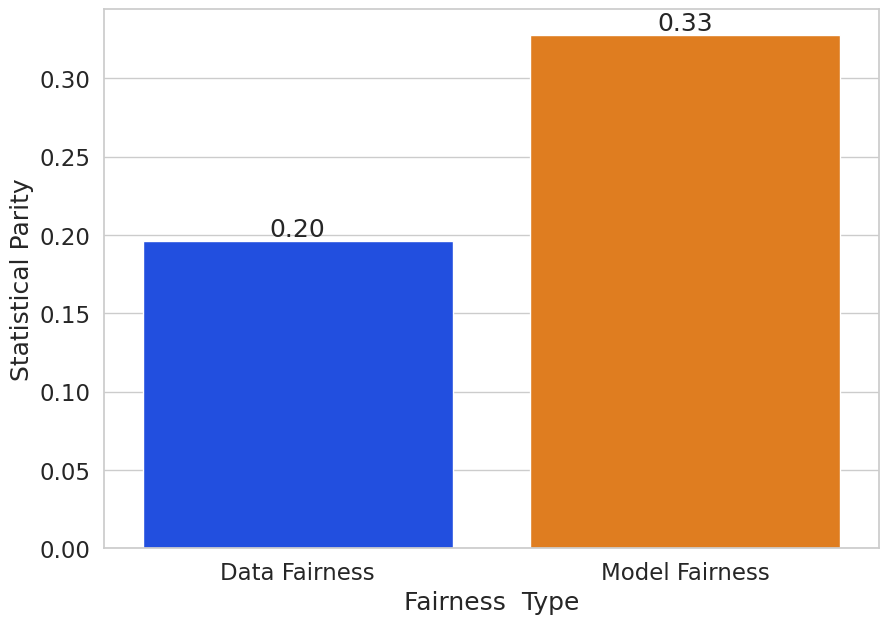

In [24]:
ax = sns.barplot(
        x='Fairness  Type',
        y='Statistical Parity',
        data=pd.DataFrame({
            'Fairness  Type': ['Data Fairness', 'Model Fairness'],
            'Statistical Parity': [parity_test_data, parity_test_model],
        })
)
ax.bar_label(ax.containers[0], fmt='%.2f')

<a id='Fairness-measure_other'></a>
#### Other Fairness Metrics
Statistical parity is only one of the many supported fairness metrics. As another example, we can compute Equalized Odds, which measures the disparity of a model’s true positive and false positive rates between different subgroups of the data based on demographic information/protected attributes.

In [25]:
from automl.fairness.metrics import EqualizedOddsScorer

fairness_score = EqualizedOddsScorer(protected_attributes='sex', distance_measure='diff')
EO_original = fairness_score(model, X_test, y_test)
print(f'Equalized odds on test data (lower is better): {EO_original:.2f}')

Equalized odds on test data (lower is better): 0.23


We can also easily compute these fairness metrics on more than one protected attribute.

In [26]:
fairness_score = EqualizedOddsScorer(protected_attributes=['sex', 'race'], distance_measure='diff')
EO = fairness_score(model, X_test, y_test)
print(f'Equalized odds on test data (lower is better): {EO:.2f}')

Equalized odds on test data (lower is better): 0.12


Note that, unlike statistical parity, we cannot compute equalized odds on the dataset since it is dependent to model output. However, we can compute other metrics on the dataset like `Smoothed EDF`; it is computed as the minimal exponential deviation of positive target ratios comparing a subgroup to the rest of the population.

In [27]:
from automl.fairness.metrics import smoothed_edf

subgroups = X_train[['race', 'sex']]
smoothed_edf_score = smoothed_edf(y_train, subgroups)
print(f'Smoothed EDF score on train data: {smoothed_edf_score:.2f}')

Smoothed EDF score on train data: 1.71


<a id='MLX'></a>
## Revealing Bias with Explainability
For a variety of decision-making tasks, getting only a prediction as model output is not sufficient. A user may wish to know why the model outputs that prediction, or which data features are relevant for that prediction. For that purpose the Oracle AutoMLx solution defines the MLExplainer factory function, which allows to compute a variety of model explanations.

<a id='MLX-initializing'></a>
### Initializing an MLExplainer

The `MLExplainer` object takes as argument the trained model, the training data and ground truth labels, as well as the task.

In [28]:
explainer = automl.MLExplainer(model,
                               X_train,
                               y_train,
                               target_names=["<=50K", ">50K"],
                               task="classification")

<a id='MLX-global'></a>
### Model Explanations (Global Feature Importance)
The notion of global feature importance intuitively measures how much the model's performance (relative to the provided train labels) would change if a given feature were dropped from the dataset, <b><i>without</i></b> retraining the model. This notion of feature importance considers each feature independently from all other features.

In [29]:
global_exp = explainer.explain_model()

There are two options to show the explanation's results:
- `to_dataframe()` will return a dataframe of the results.
- `show_in_notebook()` will show the results as a bar plot.

The features are returned in decreasing order of importance.

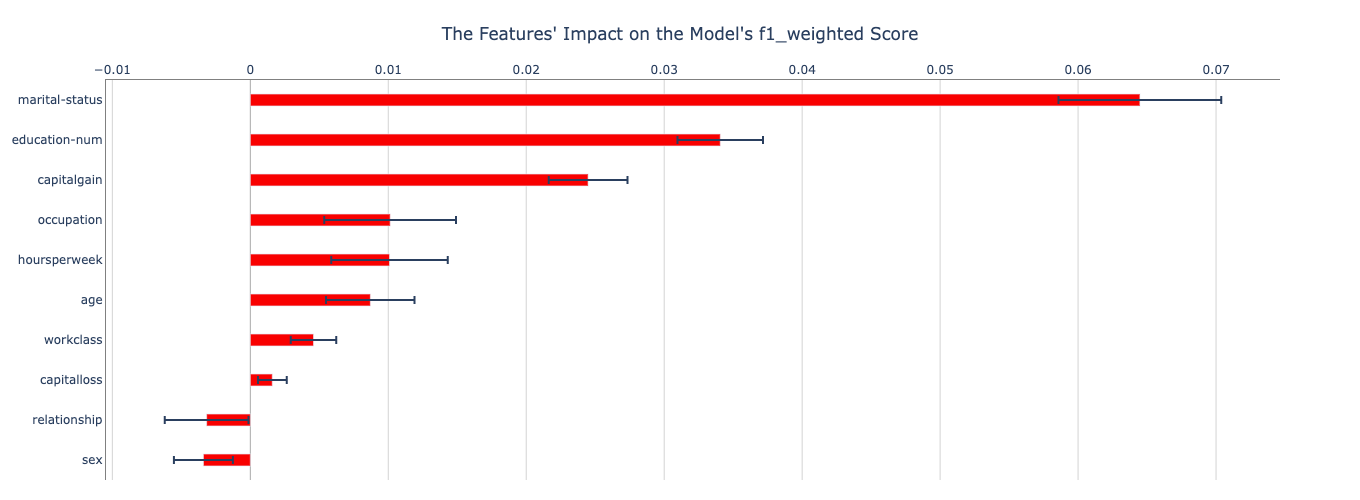

In [30]:
global_exp.show_in_notebook()

<a id='MLX-fairness-feature-importance'></a>
### Model Fairness Explanations (Fairness Feature Importance)
The <a href='#MLX-global'>Global Feature Importance</a> attributions can be computed for fairness metrics using the `explain_model_fairness()` method, which provides 95% confidence intervals for each fairness feature importance attribution.

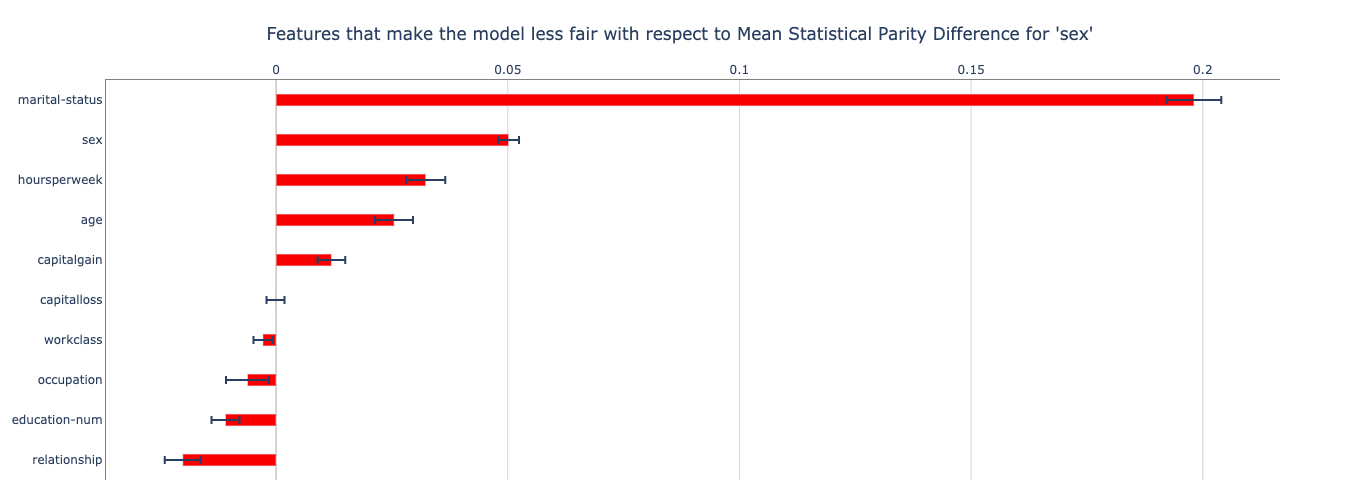

In [31]:
fairness_exp = explainer.explain_model_fairness(protected_attributes='sex', 
                                                scoring_metric='statistical_parity')
fairness_exp.show_in_notebook()

Here, we see that `marital-status` is considered to be the feature that contributes most to the model's unfairness.
Note that fairness feature importance has to be interpreted slightly differently: the most important features are the ones that **contributed the most to make the model unfair**.
For that purpose, below, we compare these two types of explanations.

<a id='MLX-fairness-vs-global'></a>
### Global vs Fairness Feature Importance
Let's plot a feature's fairness importance according to its global importance to highlight the difference between the two.

In [32]:
def compare(global_exp, fairness_exp):
    dfg = global_exp.to_dataframe()
    dff = fairness_exp.to_dataframe()
    
    dfg = dfg.set_index('feature')
    dff = dff.set_index('feature')
    
    dfg.columns = [f'{col}_score' for col in dfg.columns]
    dff.columns = [f'{col}_fairness' for col in dff.columns]
    
    df = pd.concat([dfg, dff], axis=1)
    
    df = df.reset_index()
    
    df.columns = ['Feature', 'Increases Accuracy', 'Upper-bound Accuracy', 'Lower-bound Accuracy', 
                  'Decreases Fairness', 'Upper-bound Fairness', 'Lower-bound Fairness',]

    fig = px.scatter(df, x="Increases Accuracy", y="Decreases Fairness", text="Feature", log_x=False, size_max=60)

    fig.update_traces(textposition='middle left')

    fig.update_layout(
        height=800,
        title_text='Global vs Fairness Feature Importance'
    )

    fig.show()

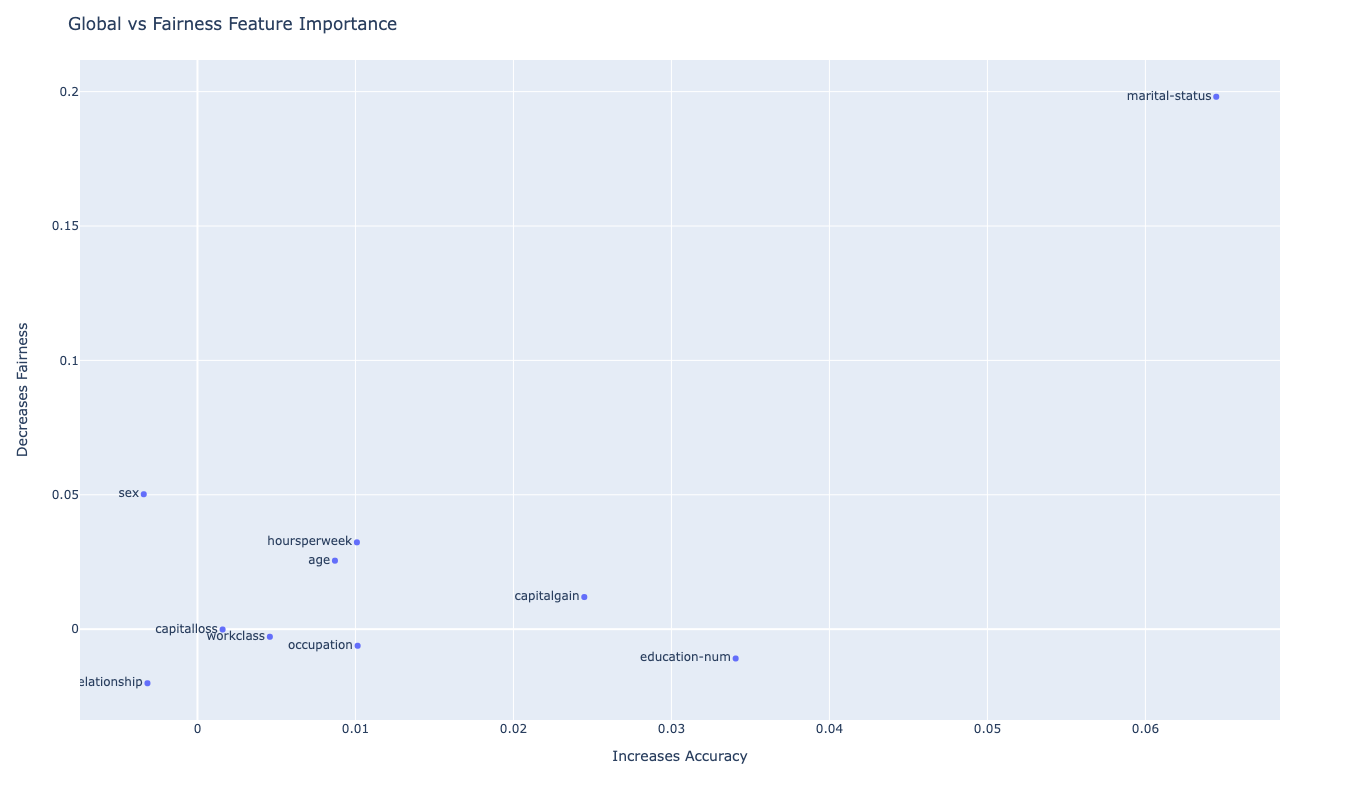

In [33]:
compare(global_exp, fairness_exp)

<a id='MLX-dependency-accuracy'></a>
### Feature Dependence Explanations (Important to Accuracy)
A way to measure dependency on a feature is through a partial dependence plots (PDP). Given a dataset, a PDP displays the average output of the model as a function of the value of the selected set of features. 
PDPs are particularly useful to understanding statistical parity fairness, but not necessarily other types of fairness, like equalized odds. The example below shows how the output of the model changes with respect to `education-num` (that is the number of years of education) for values of `sex`.

In [34]:
fd_exp = explainer.explain_feature_dependence(['sex', 'education-num'])

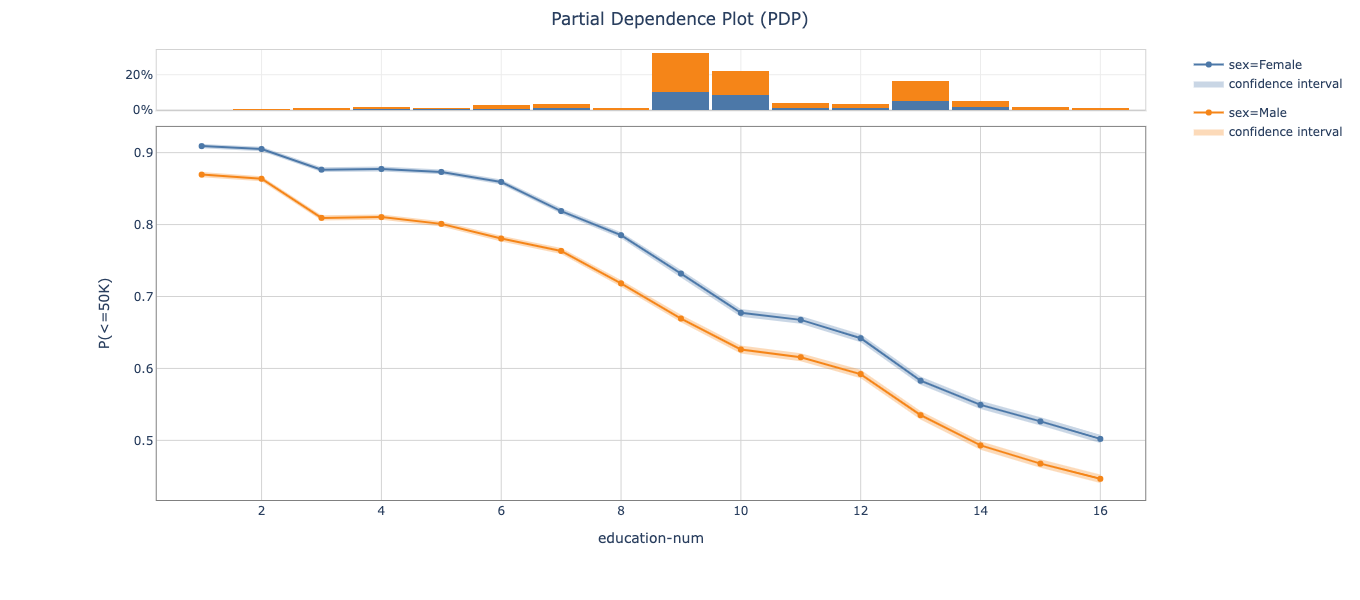

In [35]:
fd_exp.show_in_notebook()

We can observe that while clearly women are more likely to have a lower income, the difference between the outcomes is more or less the same for all education levels. Moreover, the top bar plot shows that the dataset is relatively balanced between the sexes for all education levels.

<a id='MLX-dependency-fairness'></a>
### Feature Dependence Explanations (Important to Fairness)

In [36]:
fd_exp = explainer.explain_feature_dependence(['sex', 'marital-status'])

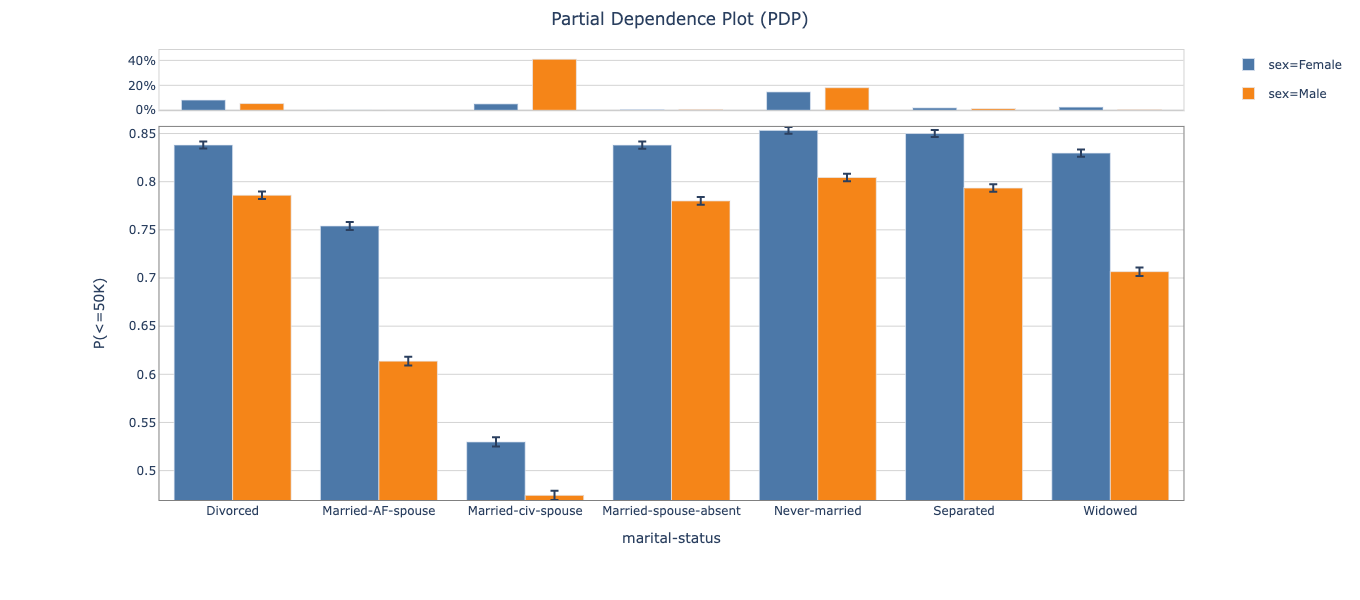

In [37]:
fd_exp.show_in_notebook()

In this case, the figure has automatically changed to bar plots, because both features are categorical.
We remember from <a href='#MLX-fairness-feature-importance'>Fairness Feature Importance</a> that `marital-status` is the feature that contributed most to unfairness. Here we can see two potential reasons that caused that:
- The main source is that if the `marital-status` is married to a civilian (`Married-civ-spouse`), then you are both most likely to be male and unlikely to have a low income.
- Second is that if your are married to an armed force’s spouse (`Married-AF-spouse`), then women are much more likely to have a lower income than men (compared to the disparities for the other groups).


<a id='MLX-local-shap'></a>
### Local Feature Importance with Kernel SHAP
Using this method, feature importance attributions will be calculated using an approximation of the Shapley value method. It typically provides relatively high-quality approximations; however, it currently does not provide confidence intervals.

In [38]:
explainer.configure_explain_prediction(tabulator_type='kernel_shap')

In [39]:
lfi_exp = explainer.explain_prediction(X_test.iloc[:5])

In [40]:
X_test_copy = copy.deepcopy(X_test.head(5))
X_test_copy['P(<=50k)'] = model.predict_proba(X_test_copy)[:,0]
X_test_copy.reset_index(drop=True)

age         workclass    fnlwgt  education  education-num  \
0    2           Private  151856.0    HS-grad            9.0   
1    4  Self-emp-not-inc   87584.0  Doctorate           16.0   
2    1         Local-gov  220669.0  Bachelors           13.0   
3    3           Private  171355.0  Assoc-voc           11.0   
4    4  Self-emp-not-inc  148626.0       10th            6.0   

       marital-status         occupation   relationship   race     sex  \
0  Married-civ-spouse    Protective-serv        Husband  White    Male   
1            Divorced     Prof-specialty  Not-in-family  White  Female   
2       Never-married     Prof-specialty      Own-child  White  Female   
3  Married-civ-spouse  Machine-op-inspct        Husband  White    Male   
4  Married-civ-spouse    Farming-fishing        Husband  White    Male   

   capitalgain  capitalloss  hoursperweek native-country  P(<=50k)  
0            0            0             2  United-States  0.339765  
1            0            0             1  United-States  0.598338  
2            2            0             2  United-States  0.870428  
3            0            0             0  United-States  0.622580  
4            0            0             2  United-States  0.745454

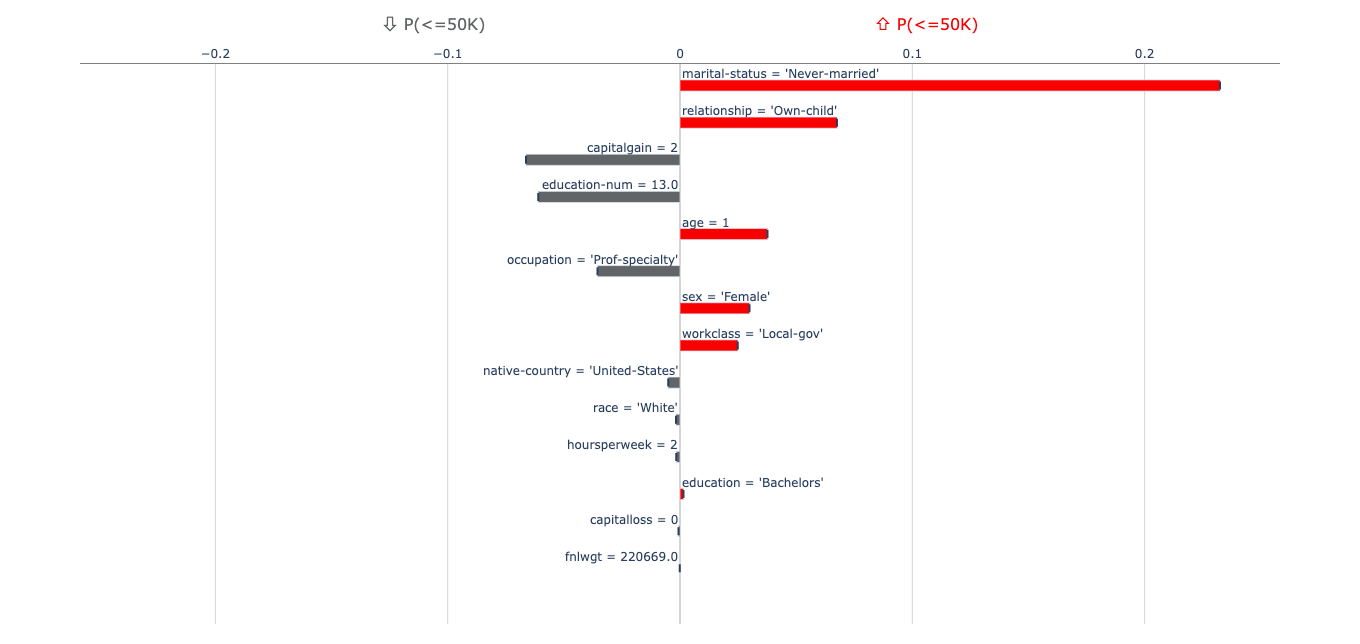

In [41]:
lfi_exp[2].show_in_notebook()

We can again see that having `marital-status` as `never-married` is showing up as having increased the probability of a lower income by more than any other feature, which reveals more about the bias.

<a id='MLX-fast-cf'></a>
### Fast Counterfactual Explanations
This explainer enables us to play with the model by tweaking its input features. For example, by changing an individual's sex, keeping all else equal, what would happen to the model prediction? This does not measure any specific fairness metric; however, it might give us insight into the model's behavior.

In [42]:
cf_exp = explainer.explain_counterfactual(X_test.iloc[:5])

In [43]:
cf_exp[2].show_in_notebook()

<a id='MLX-fairness-mitigation'></a>
# Enforcing Fairness in the Model is Not Straight-forward
Recall the <a href='#MLX-fairness-feature-importance'>Fairness Feature Importance</a> explained above. We learned from fairness feature importance that `marital-status` contributes most to unfairness with respect to `sex`. Let's see what would happen if we simply drop this feature from the dataset and train a new model that we call **blind** (to some protected attributes).

In [44]:
to_drop = ['marital-status']

X_train_filtered = X_train.drop(to_drop, axis=1)
X_test_filtered = X_test.drop(to_drop, axis=1)

In [45]:
model.fit(X_train_filtered, y_train)

[2023-05-01 01:48:30,671] [automl.pipeline] Dataset shape: (34189, 13)
[2023-05-01 01:48:30,680] [automl.pipeline] Running Auto-Preprocessing
[2023-05-01 01:48:30,902] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (34189, 14), cv: 5
[2023-05-01 01:48:30,927] [automl.pipeline] SVC, KNeighborsClassifier are disabled for datasets with > 10K samples or > 1K features
[2023-05-01 01:48:30,928] [automl.pipeline] Running Model Selection
[2023-05-01 01:48:39,042] [automl.pipeline] Model Selection completed. Selected model: ['LGBMClassifier']
[2023-05-01 01:48:39,044] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (34189, 14), Valid Shape: None, CV: 5, Class counts: [25955  8234]
[2023-05-01 01:48:41,191] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (34189, 14), Valid Shape: None, CV: [(12342, 6838), (12342, 6838), (12342, 6838), (12342, 6838), (12342, 6837)], Class counts: [25955  8234]
[2023-05-01 01:48:41,192] [automl.pipeline] Startin

Pipeline(model_list=['DecisionTreeClassifier', 'ExtraTreesClassifier',
                     'GaussianNB', 'LGBMClassifier', 'LogisticRegression',
                     'RandomForestClassifier', 'SVC', 'XGBClassifier',
                     'TorchMLPClassifier', 'CatBoostClassifier'])

In [46]:
fairness_score = ModelStatisticalParityScorer('sex')

Statistical parity of the blind model on test data (lower is better): 0.33
Statistical parity of the original model on test data (lower is better): 0.33
Improvement: 0.98


[Text(0, 0, '0.328'), Text(0, 0, '0.334')]

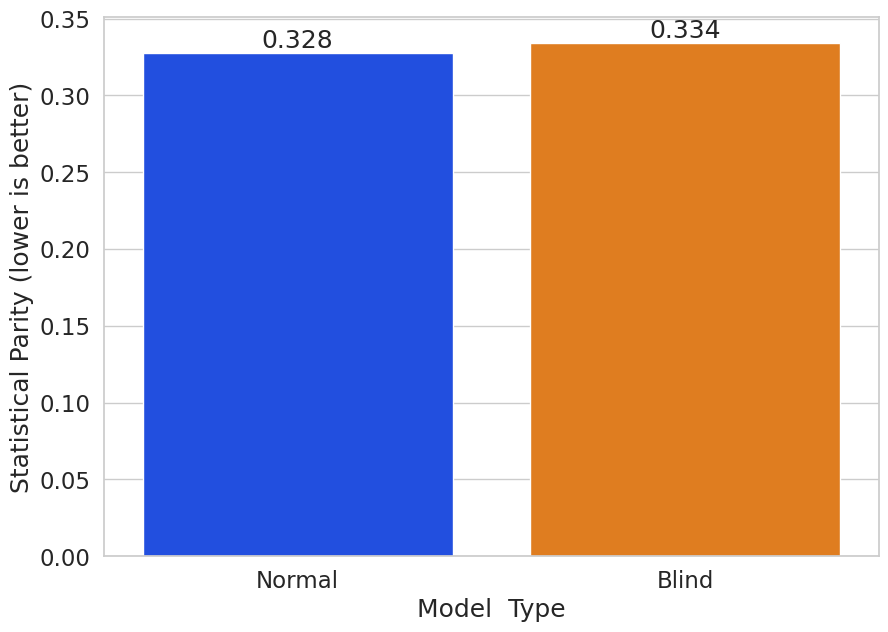

In [47]:
parity_filtered = fairness_score(model, X_test_filtered)
parity_original = parity_test_model  # taken from previous cells

print(f'Statistical parity of the blind model on test data (lower is better): {parity_filtered:.2f}\n'
      f'Statistical parity of the original model on test data (lower is better): {parity_original:.2f}\n'
      f'Improvement: {parity_original/parity_filtered:.2f}')

ax = sns.barplot(
        x = 'Model  Type', 
        y = 'Statistical Parity (lower is better)', 
        data = pd.DataFrame({'Model  Type': ['Normal', 'Blind'], 
                             'Statistical Parity (lower is better)': [parity_original, parity_filtered]})
)
ax.bar_label(ax.containers[0], fmt='%.3f')

We can see that this has actually worsened the unfairness of the model. We know that features are not independent and sensitive information can be hidden in other proxy features. So simply removing a feature does not necessarily improve fairness. Let's see the effect on fairness feature importance.

In [48]:
explainer = automl.MLExplainer(model,
                               X_train_filtered,
                               y_train,
                               target_names=["<=50K", ">50K"],
                               task="classification")

In [49]:
fairness_exp = explainer.explain_model_fairness(fairness_score)

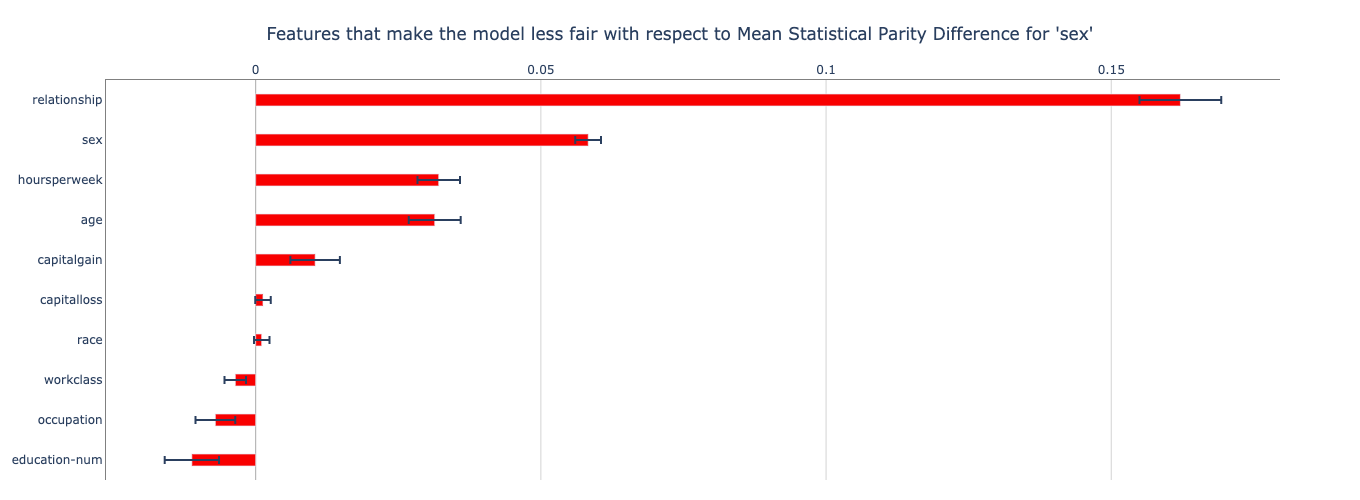

In [50]:
fairness_exp.show_in_notebook()

Now, as another naive approach, let's remove even more features, hoping to break the flow of sensitive information and overcome unfairness.

In [51]:
to_drop = ['marital-status', 'sex', 'relationship']

X_train_filtered = X_train.drop(to_drop, axis=1)
X_test_filtered = X_test.drop(to_drop, axis=1)

In [52]:
model.fit(X_train_filtered, y_train)

[2023-05-01 01:49:52,502] [automl.pipeline] Dataset shape: (34189, 11)
[2023-05-01 01:49:52,513] [automl.pipeline] Running Auto-Preprocessing
[2023-05-01 01:49:52,696] [automl.pipeline] Preprocessing completed. Updated Dataset shape: (34189, 11), cv: 5
[2023-05-01 01:49:52,720] [automl.pipeline] SVC, KNeighborsClassifier are disabled for datasets with > 10K samples or > 1K features
[2023-05-01 01:49:52,722] [automl.pipeline] Running Model Selection
[2023-05-01 01:50:01,784] [automl.pipeline] Model Selection completed. Selected model: ['CatBoostClassifier']
[2023-05-01 01:50:01,788] [automl.pipeline] Running Adaptive Sampling. Dataset Shape: (34189, 11), Valid Shape: None, CV: 5, Class counts: [25955  8234]
[2023-05-01 01:50:03,989] [automl.pipeline] Adaptive Sampling Completed. Updated Dataset Shape: (34189, 11), Valid Shape: None, CV: [(12342, 6838), (12342, 6838), (12342, 6838), (12342, 6838), (12342, 6837)], Class counts: [25955  8234]
[2023-05-01 01:50:03,991] [automl.pipeline] Sta

Pipeline(model_list=['DecisionTreeClassifier', 'ExtraTreesClassifier',
                     'GaussianNB', 'LGBMClassifier', 'LogisticRegression',
                     'RandomForestClassifier', 'SVC', 'XGBClassifier',
                     'TorchMLPClassifier', 'CatBoostClassifier'])

Now, we would like to compute statistical parity with respect to `sex`; however, `sex` itself is not included in the data on which the blind model was trained. For that matter, we use the optional argument of `supplementary_features` and provide the scorer with the column with respect to which we would like to compute the fairness metric - that being the original `sex` column in this case.

Statistical parity of the blind model on test data (lower is better): 0.13
Statistical parity of the original model on test data (lower is better): 0.33
Improvement: 2.4469


[Text(0, 0, '0.33'), Text(0, 0, '0.13')]

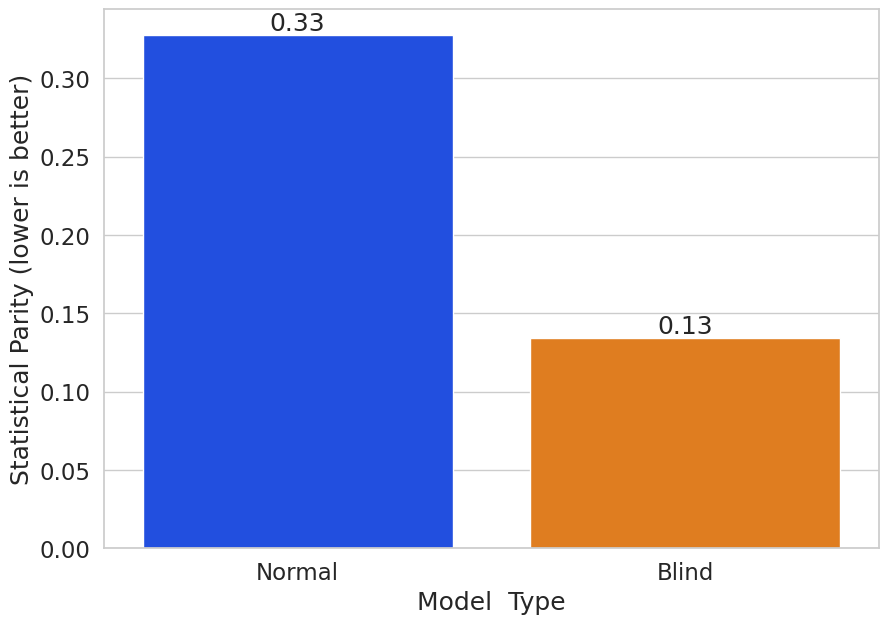

In [53]:
parity_filtered = fairness_score(model, X_test_filtered, supplementary_features=X_test[['sex']])

print(f'Statistical parity of the blind model on test data (lower is better): {parity_filtered:.2f}\n'
      f'Statistical parity of the original model on test data (lower is better): {parity_original:.2f}\n'
      f'Improvement: {parity_original/parity_filtered:.4f}')

ax = sns.barplot(
        x = 'Model  Type', 
        y = 'Statistical Parity (lower is better)', 
        data = pd.DataFrame({'Model  Type': ['Normal', 'Blind'], 
                             'Statistical Parity (lower is better)': [parity_original, parity_filtered]})
)
ax.bar_label(ax.containers[0], fmt='%.2f')

Voila! We can see that statistical parity has improved improved substantially and the model is more fair, meaning that we successfully removed most of the unintended bias from the dataset. But what is the price?

Score of the blind model on test data: 0.86
Score of the original model on test data: 0.91
Degradation: 0.94


[Text(0, 0, '0.91'), Text(0, 0, '0.86')]

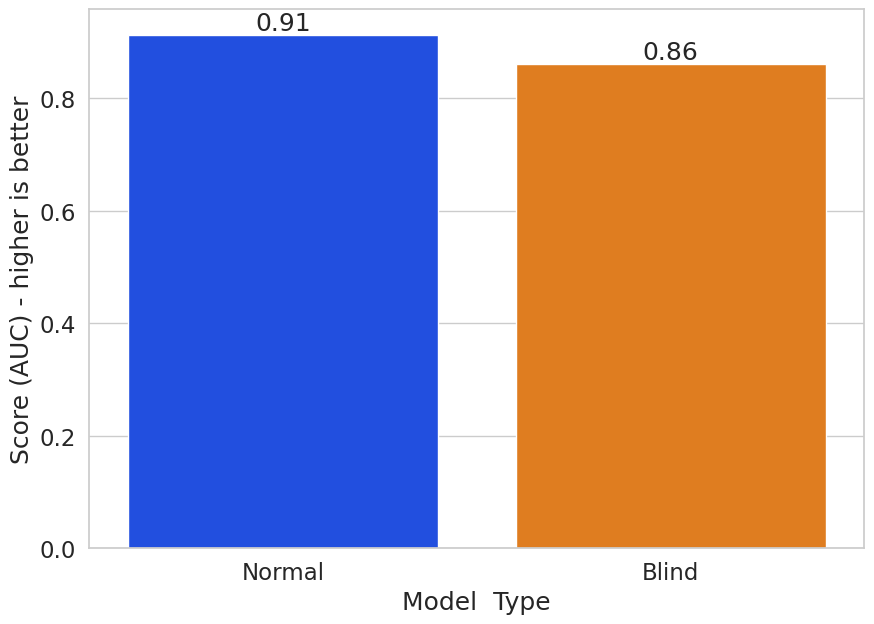

In [54]:
y_proba = model.predict_proba(X_test_filtered)
score_filtered = roc_auc_score(y_test, y_proba[:, 1])

print(f'Score of the blind model on test data: {score_filtered:.2f}\n'
      f'Score of the original model on test data: {score_original:.2f}\n'
      f'Degradation: {score_filtered/score_original:.2f}')

ax = sns.barplot(
        x = 'Model  Type', 
        y = 'Score (AUC) - higher is better', 
        data = pd.DataFrame({'Model  Type': ['Normal', 'Blind'], 
                             'Score (AUC) - higher is better': [score_original, score_filtered]})
)
ax.bar_label(ax.containers[0], fmt='%.2f')

Unfortunately, the price is somewhat high, but may be acceptable, depending on the application context. Nevertheless, upcoming AutoMLx releases will include automated bias mitigation strategies that should help to minimize the performance degradations while maximizing fairness.

<a id='ref'></a>
## References
* More examples and details: http://automl.oraclecorp.com/
* Oracle AutoML http://www.vldb.org/pvldb/vol13/p3166-yakovlev.pdf
* scikit-learn https://scikit-learn.org/stable/
* UCI https://archive.ics.uci.edu/ml/datasets/Adult
* Big Data and Social Science https://textbook.coleridgeinitiative.org/